In [45]:
import pandas as pd
import nltk
import re
import gensim

from sklearn.manifold import TSNE

import matplotlib
import matplotlib.pyplot as plt

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

import pyLDAvis.gensim

try: 
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
except ImportError:
    pass

S

In [4]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# LDA 

Latent Dirichlet Allocation ([LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)) is a statistical model used to divide a dataset into groups. The model attempts to create these groups by placing similar pieces of data together. These groups may or may not be inherent within the dataset. Within machine learning, this approach could be classified as unsupervised learning because the model is discovering groups without being informed about the desired outcome. Instead, some metric is meant to be optimized.

When applied in natural language processing settings, LDA is most commenly used to extract topics from the various pieces of text provided. The idea is that the various pieces of text will be composed of numerous topics each signified through the words used in the text.

Applied here, we attempted to see if unique topics could be found within the COVID-19 related tweets that we gathered. To achieve this, we first cleaned and prepared the text for the model then analyzed the best number of topics, and finally trained and reviewed the results of our model. More details regarding each step can be found below.


__Some of the code in this section may appear as duplicate. This is intentional for now due to this being a unique effort from other forms of analysis that requires slightly different processes in the duplicated sections such s preprocessing and cleaning.__


## Load Data

In [5]:
DATA_FILE = './twenty_politicians.csv'
KEYWORDS_FILE = './covid_keywords.txt'

In [6]:
# Loading the tweets
df = pd.read_csv(DATA_FILE, index_col=0)
df['Created'] = pd.to_datetime(df['Created'])

print(df.shape)
df.head()

(20270, 8)


,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached
0,Donald J. Trump,realDonaldTrump,I will be having a White House Press Conferenc...,2020-04-24 20:51:16,24462,5259,False,False
1,Donald J. Trump,realDonaldTrump,https://t.co/x8Yguxf4Ks,2020-04-24 20:13:18,17264,3781,False,True
2,Donald J. Trump,realDonaldTrump,I will never let our Post Office fail. It has ...,2020-04-24 19:08:09,69032,13920,False,False
3,Donald J. Trump,realDonaldTrump,🚨 President Trump just signed the Paycheck Pro...,2020-04-24 17:02:47,0,5054,True,False
4,Donald J. Trump,realDonaldTrump,#BREAKING: President @RealDonaldTrump just sig...,2020-04-24 17:02:20,0,3843,True,False


In [7]:
# loading the keywords file
keywords = []

with open(KEYWORDS_FILE, 'r') as f:
    for line in f:
        keywords.append(re.escape(line.strip().lower()))
        
keywords[:5]

['unemployment', 'front\\ line', 'testing', 'health', 'public\\ health']

## Preprocessing tweets

The tweets are processed by first lowercasing all strings and only including those of which contains words or phrases present in the keywords (loaded above). During this step we also remove all non-alphanumeric characters, stopwords, and words with less than 3 letters. Additionally, words are also lemmatized meaning they are reduced to their root form. This allows for a more generalizable analysis.

Each entry is also divided into n-grams as well. N-grams are phrases of n words within the text. For this analysis, we used bi- and tri-grams, that is two and three word phrases. N-grams are used because in general, words gain meaning through context. By looking at groups of words, more meaningful text is usually extracted.

In [9]:
def part_of_speech(word):
    ''' Identifies the Part of Speech for given word '''
    pos = nltk.pos_tag([word])[0][1][0].upper()
    pos_dict = {
        'J' : wordnet.ADJ,
        'N' : wordnet.NOUN,
        'V' : wordnet.VERB,
        'R' : wordnet.ADV
    }
    
    return pos_dict.get(pos, wordnet.NOUN)

def clean_text(text, word_length=2, add_stopwords=None):
    ''' Cleans the given text '''
    
    # lowercased, only alpha-numeric, greater than word_length
    clean = text.lower()
    clean = re.sub(r'[^a-zA-Z]|(\w+:\/\/\S+)',' ', clean).split()
    clean = [word for word in clean if len(word) > word_length]
    
    # lemmatize (convert to base word) w/ part of speech considered
    lemmatizer = WordNetLemmatizer()
    clean = [lemmatizer.lemmatize(word, part_of_speech(word)) for word in clean]
    
    # removing stop words in nltk's english stopwords plus additional
    stops = set(stopwords.words('english'))
    
    if add_stopwords:
        stops.add(add_words)
    
    clean = [word for word in clean if word not in stops]
    
    return clean

def ngrams_list(text, lower=1, upper=2):
    ngram_list = []
    for i in range(lower, upper):
        for ngram in ngrams(text, i):
            ngram_list.append(' '.join(str(word) for word in ngram))
            
    return ngram_list
    
    
def clean_tweets(tweet_df, keywords=None):
    ''' Cleans and processes all tweets in df, returns new df'''
    # copying the dataframe
    clean_df = tweet_df.copy()
    
    # converting everything to lowercase
    clean_df['Text'] = clean_df['Text'].str.lower()
    
    # Gathering only tweets with keywords if given
    if keywords:
        clean_df = clean_df[clean_df['Text'].str.contains('|'.join(keywords))]
    
    # Cleaning and tokenizing tweets
    clean_df['tokens'] = clean_df['Text'].apply(lambda x: clean_text(x))
    
    # removing rows without any tokens
    clean_df = clean_df[clean_df['tokens'].map(bool)]
    
    return clean_df

In [20]:
# Cleaning the tweets 
clean_df = clean_tweets(df, keywords=keywords)

# Getting all the bi- and tri-grams 
clean_df['ngrams'] = clean_df['tokens'].apply(lambda x: ngrams_list(x, 2, 3))

clean_df.head()

,Name,Username,Text,Created,Favorite Count,Retweet Count,Retweeted,Media Attached,tokens,ngrams
2,Donald J. Trump,realDonaldTrump,i will never let our post office fail. it has ...,2020-04-24 19:08:09,69032,13920,False,False,"[never, let, post, office, fail, mismanage, ye...","[never let, let post, post office, office fail..."
3,Donald J. Trump,realDonaldTrump,🚨 president trump just signed the paycheck pro...,2020-04-24 17:02:47,0,5054,True,False,"[president, trump, sign, paycheck, protection,...","[president trump, trump sign, sign paycheck, p..."
4,Donald J. Trump,realDonaldTrump,#breaking: president @realdonaldtrump just sig...,2020-04-24 17:02:20,0,3843,True,False,"[break, president, realdonaldtrump, sign, legi...","[break president, president realdonaldtrump, r..."
5,Donald J. Trump,realDonaldTrump,✓ signed\n\npresident @realdonaldtrump just si...,2020-04-24 17:02:05,0,3627,True,False,"[sign, president, realdonaldtrump, sign, phase...","[sign president, president realdonaldtrump, re..."
6,Donald J. Trump,realDonaldTrump,great conversation with president lenin moreno...,2020-04-24 14:59:34,55045,12152,False,False,"[great, conversation, president, lenin, moreno...","[great conversation, conversation president, p..."


## Training LDA

Within this section, we train the LDA model by first performing multiple small models in order to find the best configuration. Based on this, we then perform a more in depth training with the chosen settings.

Below are parameters used throughout the remainder of the notebook. `RANDOM_STATE` seeds the random aspect of the model allowing for reproducible results.

In [11]:
# Parameters
RANDOM_STATE = 23

In [21]:
# Creating a dictionary mapping word -> id
dictionary = gensim.corpora.Dictionary(clean_df['ngrams'])

# removes tokens that appear in less than 10 documents or over 50%
dictionary.filter_extremes(no_below=10, no_above=0.5)

doc_bags = [dictionary.doc2bow(x) for x in clean_df['ngrams']]

tfidf = gensim.models.TfidfModel(doc_bags)
corpus = tfidf[doc_bags]

In [90]:
def eval_lda(corpus, dictionary, texts, num_topics, alpha, beta):
    ''' Used to evaluate an LDA model trained with the given input values based on coherence score '''
    lda_model = gensim.models.ldamulticore.LdaMulticore(
                                     corpus=corpus, 
                                     num_topics=num_topics, 
                                     id2word=dictionary, 
                                     passes=10, 
                                     alpha=alpha,
                                     eta=beta,
                                     random_state=RANDOM_STATE)
    
    perp = lda_model.log_perplexity(corpus)
    cm_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, corpus=corpus, coherence='c_v')
    coh = cm_lda.get_coherence()
    print(f'Topics: {num_topics}, alpha: {alpha}, beta: {beta}, perplexity: {perp}, coherence: {coh}')
    return perp, coh

Below we train a range of LDA models testing the desired settings. For each model, the log perplexity and coherence scores are recorded. The scores resemble different aspects about regarding the text, but a lower perplexity is better. The higher the coherence, the better. Some studies believe that perplexity does not necessarily align with the 'human-interpretability' of the text. Coherence is believed to be preferred for this.

We chose to prioritize coherence in our decision. With our training models, we only varied the number of topics for now. In the future, we may experiment with more settings. The graph below shows that coherence seems to plateau at 15 topics, so we continued with 15 topics.

In [92]:
min_topics = 2
max_topics = 40
alphas = [0.001]    # document-topic density: topics contained within documents
betas = ['auto']                   # word-topic density: how many words from dictionary are contained within each topic

results = []

for k in range(min_topics, max_topics + 1):
    for alpha in alphas:
        for beta in betas:
            perp, coh = eval_lda(corpus, dictionary, clean_df['ngrams'].values, k, alpha, beta)
            results.append((k, alpha, beta, perp, coh))

Topics: 2, alpha: 0.001, beta: auto, perplexity: -7.002110655009065, coherence: 0.5032810123224813
Topics: 3, alpha: 0.001, beta: auto, perplexity: -7.203118819746741, coherence: 0.5376369423754247
Topics: 4, alpha: 0.001, beta: auto, perplexity: -7.385144948820041, coherence: 0.5712802005258477
Topics: 5, alpha: 0.001, beta: auto, perplexity: -7.541038031658946, coherence: 0.5395776717334028
Topics: 6, alpha: 0.001, beta: auto, perplexity: -7.680852862839065, coherence: 0.5655571750106626
Topics: 7, alpha: 0.001, beta: auto, perplexity: -7.817272292771904, coherence: 0.5764476654748132
Topics: 8, alpha: 0.001, beta: auto, perplexity: -7.939967127228186, coherence: 0.5688178671678881
Topics: 9, alpha: 0.001, beta: auto, perplexity: -8.058205412104945, coherence: 0.5865043643458558
Topics: 10, alpha: 0.001, beta: auto, perplexity: -8.186362064326074, coherence: 0.599482377007451
Topics: 11, alpha: 0.001, beta: auto, perplexity: -8.285204777085179, coherence: 0.5915623869294862
Topics: 1

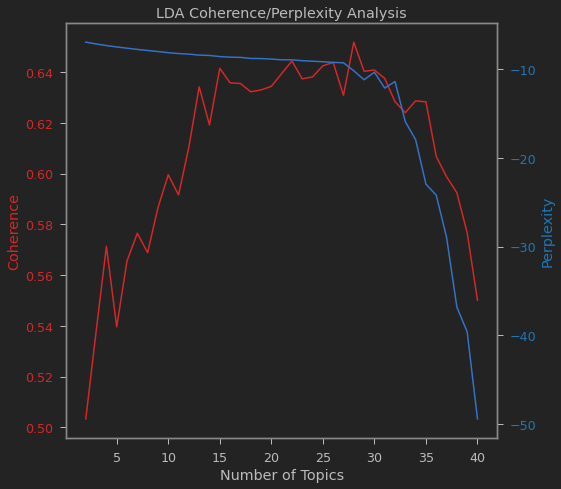

In [175]:
fig, ax1 = plt.subplots()

c1 = 'tab:red'
c2 = 'tab:blue'

ax1.set_title('LDA Coherence/Perplexity Analysis')
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence', color=c1)
ax1.plot([i[0] for i in results], [i[4] for i in results], color=c1)
ax1.tick_params(axis='y', labelcolor=c1)

ax2 = ax1.twinx()
ax2.set_ylabel('Perplexity', color=c2)
ax2.plot([i[0] for i in results],[i[3] for i in results])
ax2.tick_params(axis='y', labelcolor=c2)

fig.tight_layout()
plt.show()

In [100]:
NUM_TOPICS = 15
NUM_PASSES = 100
ALPHA = 0.001
BETA = 'auto'

lda_model = gensim.models.ldamodel.LdaModel(
                                     corpus=corpus, 
                                     num_topics=NUM_TOPICS, 
                                     id2word=dictionary, 
                                     passes=NUM_PASSES, 
                                     alpha=ALPHA,
                                     eta=BETA,
                                     random_state=RANDOM_STATE)

perp = lda_model.log_perplexity(corpus)
coh = gensim.models.CoherenceModel(model=lda_model, texts=clean_df['ngrams'].values, corpus=corpus, coherence='c_v').get_coherence()
print(f'Trained Model Statistics:\n\tCoherence: {coh}\n\tPerplexity: {perp}')

Trained Model Statistics:
	Coherence: 0.657353913873379
	Perplexity: -15.029024011821553


## Analyzing LDA 

### Visualizing LDA

The LDA model can be visualized through the python module `pyLDAvis` which provides this nice interactive graphic. The graphic depicts the topics mapped to two principal components. Hovering over a topic shows the most frequent terms within that topic as well as how frequent the term is throughout all the texts. 

Looking at the topics, none overlap, and they appear to be evenly spaced. This suggests that each topic is about something distinct within the text.

In [101]:
lda_data =  pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, mds='mmds')
pyLDAvis.display(lda_data)

### Topic Analysis

A cursorary study of the topics was done by first analyzing the five most relative words for each topic. The horizontal bar graphs below show the word as well as the weight it provides to that topic. Looking at these words, some topics seem to have separate themes, but there are others that may not be very well defined from one another as it appeared above. This lack of distinction could be due to how narrow the topic is being COVID-19. We still expected to see further separation with unique topics about the pandemic. With further analysis, we may find those.

The next analyis we performed was finding the most representative tweet for each topic. This was done by first using the model to classify each tweet to its dominant topic. This included the probability that the tweet would belong to that topic. We took the tweet with the greatest probability to be the most representative of that topic. In the printed out portion, we list the size of the topic, the tweet's author, the tweet's probability, and the tweet's text. 

Reading through the tweets, there appear to be connections between the most important words listed in the graphs, and the most representative tweet for a given topic. We plan to associate the topics with their most important words combining the two different analysis done here, but at this time we couldn't find a way to garuntee we were connecting the correct two.

Considering the sizes, disregarding one topic that is significantly larger than the rest, the topics all float around the same sizes showing a fairly even distribution between the topics.

Going forward with our analysis, we would like to consider the author's party in our analysis. Do the topics contain more activity from one party? Are there topics that only one party partakes in? 

In [146]:
def hor_bars(data, ax):
    labels, vals = zip(*data)
    
    y_vals = np.arange(len(labels))
    
    labels = [x for x in labels]
    labels = [''] + labels
    
    ax.barh(y_vals, vals)
    ax.set_yticklabels(labels)
    ax.set_xlim(0, 0.1)
    ax.invert_yaxis()

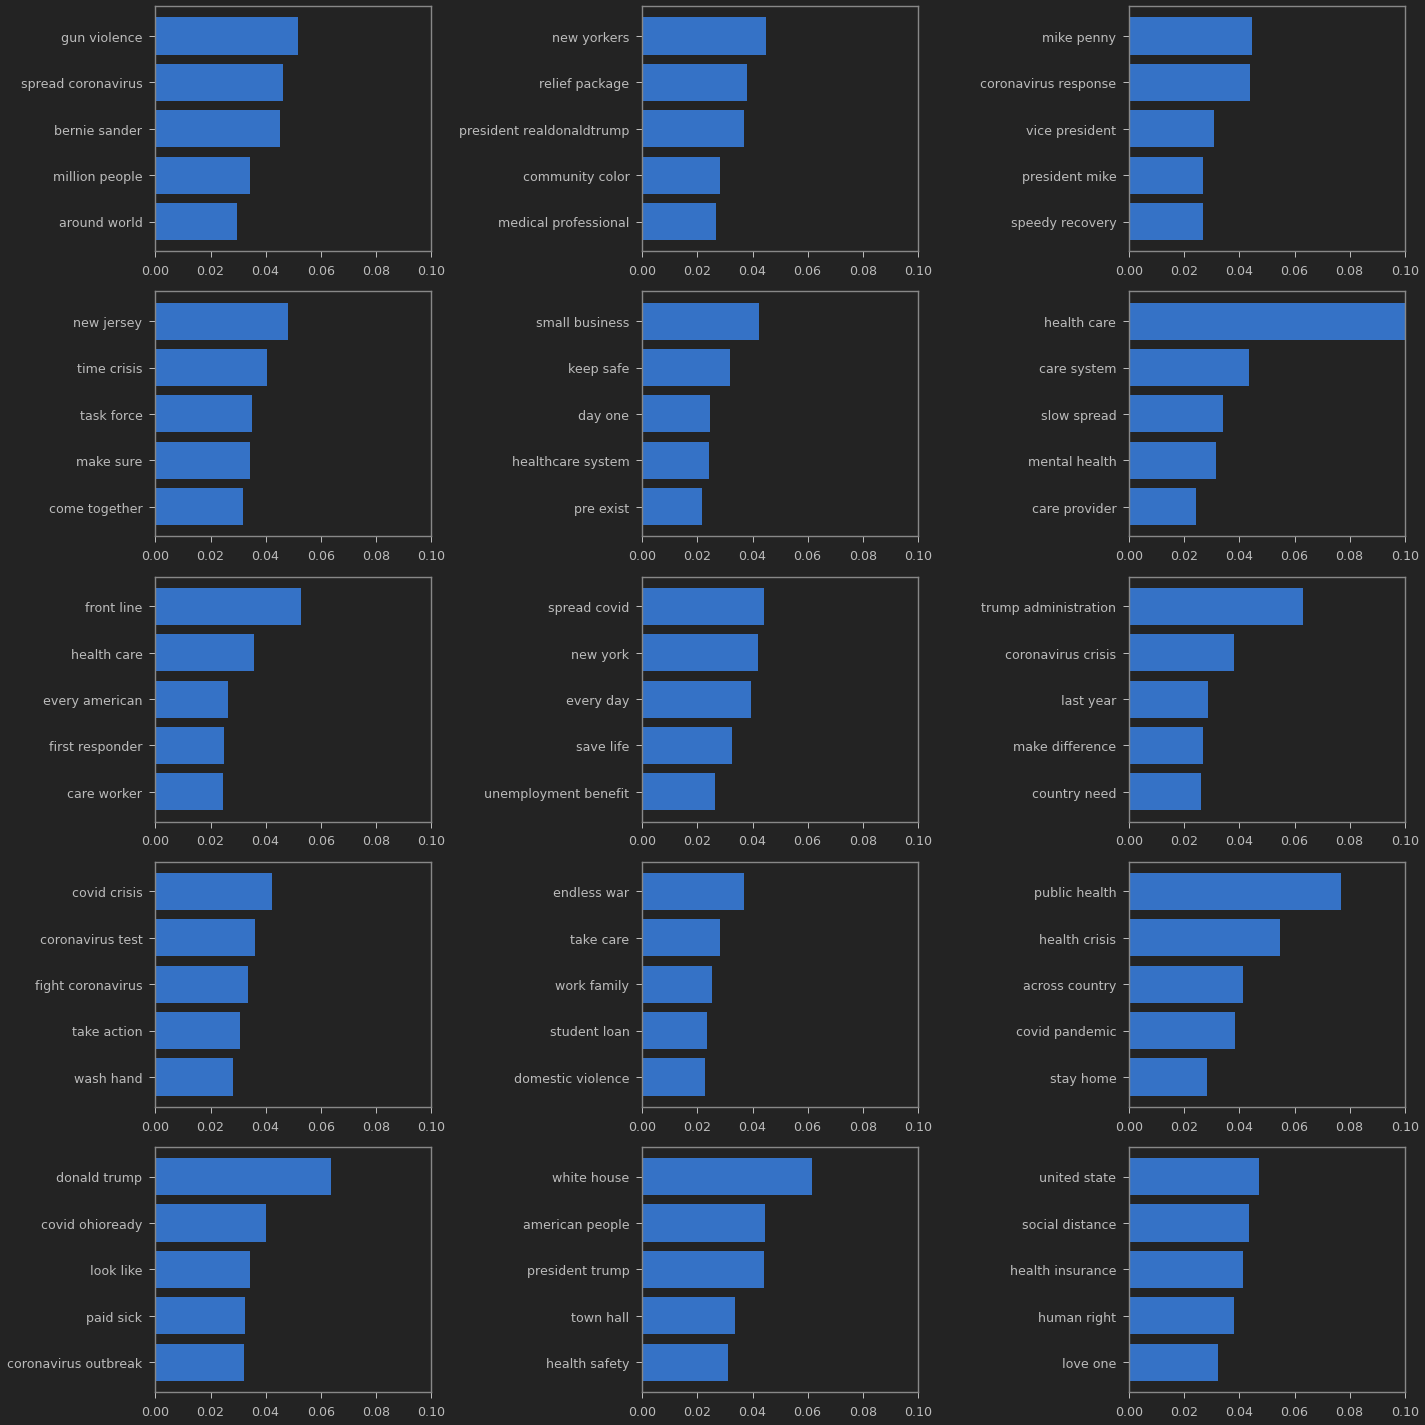

In [147]:
topics_weights = lda_model.show_topics(num_topics=NUM_TOPICS, num_words=5, formatted=False)

fig, axs = plt.subplots(5, 3, figsize=(20, 20))
axs = axs.flatten()

for topic in topics_weights:
    hor_bars(topic[1], axs[topic[0]])

plt.tight_layout()
plt.show()

In [152]:
def dominant_topic(row, model, dictionary):
    weights = model.get_document_topics(dictionary.doc2bow(row['ngrams']))
    dom_topic, dom_prob = max(weights, key=lambda x: x[1])
    row['dom_topic'] = dom_topic
    row['dom_prob'] = dom_prob
    
    return row

clean_df['dom_topic'] = -1
clean_df['dom_prob'] = -1

clean_df = clean_df.apply(lambda row: dominant_topic(row, lda_model, dictionary), axis=1)

In [176]:
dom_grps = clean_df.groupby('dom_topic')

for i, grp in dom_grps:
    best_text = grp['dom_prob'].sort_values(ascending=False).index[0]
    row = grp.loc[best_text]
    print('Topic:', i)
    print('Size:', grp.shape[0])
    print(f'\tUser w/ Most Representative Tweet: {row["Name"]}')
    print(f'Dominant probability: {row["dom_prob"]}')
    print(f'Text: {row["Text"]}')
    print()

Topic: 0
Size: 1515
	User w/ Most Representative Tweet: Elizabeth Warren
Dominant probability: 0.9972083568572998
Text: we need to treat gun violence like a public health emergency. that means we collect data about where the threats come from, and then reduce those threats. we have to be a nation committed to reducing gun violence. as president, i will reduce gun violence by 80% over eight years.

Topic: 1
Size: 491
	User w/ Most Representative Tweet: Elizabeth Warren
Dominant probability: 0.9980042576789856
Text: we need to provide immediate and comprehensive relief to consumers in the next coronavirus relief package. @sherrodbrown and i have a plan to stop banks from snatching stimulus checks, pause payments, prevent credit damage, cancel student debt, and more.  https://t.co/9io3mheldn

Topic: 2
Size: 399
	User w/ Most Representative Tweet: Governor Mike DeWine
Dominant probability: 0.999300479888916
Text: updated #covid19 data just posted to https://t.co/3lwx4irscb 

note: because 

### t-SNE Visualization

t-SNE provides a way of probabilistically performing dimensionality reduction. When applied correctly, it is very powerful and very interesting features can be found.

We attempted to reduce the dimensions down to two and three components so we could visualize it while also coloring each tweet based on the topic it belonged to. We would also like to color each tweet based on the author's political party.

Our attempts at applying t-SNE so far have not been completely successful. While our loss function (KL Divergence) appears to be reducing, the visualizations appear busy or meaningless. This could be due to an error on our part or that the data simply does not have defined topics like we believed. We will continue to look into this for future analysis.

In [109]:
weights = []
for i, row_list in enumerate(lda_model[corpus]):
    weights.append([w[1] for w in row_list])
    
tsne_arr = pd.DataFrame(weights).fillna(0).values

topic_colors = np.argmax(tsne_arr, axis=1)

col = np.array(['r', 'b', 'g', 'y', 'w'])

In [110]:
tsne = TSNE(n_components=2, verbose=1, random_state=0, perplexity=50, n_iter=10000, n_jobs=5)
tsne_lda = tsne.fit_transform(tsne_arr)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8340 samples in 0.016s...
[t-SNE] Computed neighbors for 8340 samples in 0.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8340
[t-SNE] Computed conditional probabilities for sample 2000 / 8340
[t-SNE] Computed conditional probabilities for sample 3000 / 8340
[t-SNE] Computed conditional probabilities for sample 4000 / 8340
[t-SNE] Computed conditional probabilities for sample 5000 / 8340
[t-SNE] Computed conditional probabilities for sample 6000 / 8340
[t-SNE] Computed conditional probabilities for sample 7000 / 8340
[t-SNE] Computed conditional probabilities for sample 8000 / 8340
[t-SNE] Computed conditional probabilities for sample 8340 / 8340
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.685707
[t-SNE] KL divergence after 10000 iterations: 0.267257


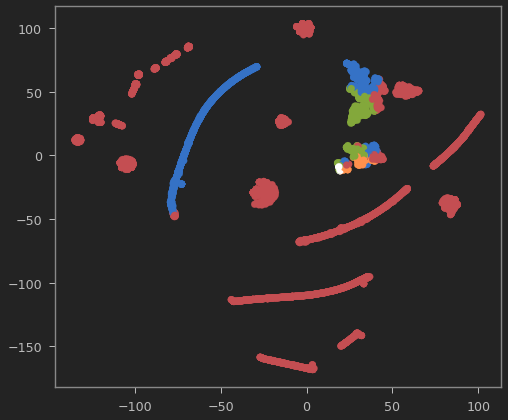

In [111]:
plt.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], c=topic_colors, cmap=matplotlib.colors.ListedColormap(col))